#  Assignment 6

## Notebook made by  

|** Name** | **Student id** | **email**|
|:- |:-|:-|
|. | | |
|  | |. |

### Pledge (taken from [Coursera's Honor Code](https://www.coursera.org/about/terms/honorcode) )



Put here a selfie with your photo where you hold a signed paper with the following text: (if this is team work, put two selfies here). The link must be to some place on the web, not to a local file. 

> My answers to homework, quizzes and exams will be my own work (except for assignments that explicitly permit collaboration).

>I will not make solutions to homework, quizzes or exams available to anyone else. This includes both solutions written by me, as well as any official solutions provided by the course staff.

>I will not engage in any other activities that will dishonestly improve my results or dishonestly improve/hurt the results of others.

<img src='link to your selfie'/>

### Note
* **Assignments without the selfies or completely filled in information will not be graded and receive 0 points.**


# P1 Parsing wikipedia

#### Hints: 
1. Gebruik de code uit `ParseWikipediaDump.ipynb` in de NoteBook folder.
2. Ontwikkel voor opgave 2:
    * eerst een versie met alleen pageid, titel en aantal woorden
    * ontwikkel de "sectie-extractor" apart op een stukje test file
    * voeg de sectie-extractor dan in je eerdere code in.


#### Opgaven
1. Haal de laatste NL wikipedia dump op van <https://dumps.wikimedia.org/nlwiki/20160111/>. **update: dit is van een eerder jaar. Verwijder de datum uit de URL, kijke wat je krijgt,  en klik op de laatste datum. Wij werken in 2017 met <https://dumps.wikimedia.org/nlwiki/20170301/>**  Je hebt de file https://dumps.wikimedia.org/nlwiki/20170301/20170301-pages-articles.xml.bz2 nodig, maar kunt als je dat wat groot vindt eerst beginnen met https://dumps.wikimedia.org/nlwiki/20170301-pages-articles1.xml.bz2
2. We gaan een dataframe maken met informatie over **elke** pagina in de NL wikipedia. Dit dataframe bevat voor elke pagina de volgende 4 kolommen:
    1. page id (dit wordt de index)
    2. titel van de pagina
    3. het aantal secties  (dus geen subsecties en dergelijke)
    4. een lijst met alle namen van de secties.
    5. het aantal woorden op de pagina (geef duidelijk in woorden aan wat je hieronder verstaat).
2. Gebuik `%time` om te timen hoe lang je programma er over doet. Zorg dat dit duidelijk in je notebook staat. Laat ook zien hoe groot je bestand is. 
    * aantal regels, aantal kolommen, aantal cellen met missende data. 
3. Sla dit dataframe op als pickle bestand. Laat met een commando (denk aan magics) zien hoe groot het is in een voor mensen leesbare eenheid (dus niet in Bytes als het meerdere Mb groot is.
3. Sla je dataframe op als csv bestand en probeer het in te lezen in Word of Openoffice en in Google spreadsheets. Rapporteer exact wat er gebeurt.
4. Maak een plot waarin je op de x-as het aantal secties zet en op de y-as het aantal paginas met zoveel secties. Zorg dat het goed leesbaar is door eventueel een log schaal te gebruiken.
5. Bereken het gemiddeld aantal secties, de mediaan, en de standaard deviatie, en geef de titel van (een?) pagina met het maximale aantal secties, en geef dat maximale aantal natuurlijk. 
    * Hoeveel paginas hebben geen secties? 
    * Is dat dan een missing data (`NaN`) of `0`. Wat is eigenlijk het verschil?
6. Plot het aantal secties tegen het aantal woorden en bereken de correlatie.
7. Wat is het gemiddeld aantal woorden per sectie op NL Wikipedia?
    * Geef eerst een sluitende definitie in woorden van dit begrip. En programmeer die dan. Wees niet te snel blij en klaar. Dit is nog best tricky. 
8. **Sectie namen**
    1. Tel voor alle sectie titels hoe vaak ze voorkomen. Laat de top 10 meest voorkomende secties zien. 
    2. Plot de sectietitels (x-as) tegen hun count (y-as) in loglog style en ga na of dat min of meer een rechte lijn is. 
        * Zo ja, dan is dit hoogstwaarschijnlijk een _power law_ (ook wel _Zipf_-verdeling genoemd) verdeling.
        * Kan je verklaren waarom sectietitels powerlaw verdeeld zijn?

#### Hint
* Denk na of de waarden die je vind ergens op slaan.
* Het is echt niet voldoende dat je het commando `df.mean()` kent. Het is echt de bedoeling dat je 

#### Voorbeeld
Voor <https://nl.wikipedia.org/wiki/Albert_Speer> ziet dit er (op dit moment van schrijven) als volgt uit:
1. page id is $1$
2. titel is _Albert Speer_
3. Aantal secties is 12
4. Sectie titels zijn (maar dan zonder de nummering)
```
1	Voor 1933
2	In dienst van Hitler
3	Speer de organisator
4	Hitlers laatste bevelen aan Speer
5	Arrestatie en gevangenisstraf
6	Speer als de 'nette nazi'
7	Nalatenschap
8	Het einde van de mythe
9	Wetenswaardig
10	Publicaties
11	Literatuur
12	Film
```


 
    
    

In [82]:
%matplotlib inline
import pandas as pd
import re
from collections import Counter
from lxml import etree 
import bz2
from bz2file import BZ2File
import codecs
import matplotlib.pyplot as plt
import os
import math

In [83]:
#1

dumps = "nlwiki-20170301-pages-articles1.xml.bz2"

In [84]:
#2

c= 0
L = []

def wikiframe():

    with BZ2File(dumps) as xml_file:    
        context = etree.iterparse(xml_file,  tag= '{http://www.mediawiki.org/xml/export-0.10/}page')
        for _, elem in context:
                    # Pageid
                    page_id = elem.findtext('{http://www.mediawiki.org/xml/export-0.10/}id') 
                    # Title
                    title= elem.findtext('{http://www.mediawiki.org/xml/export-0.10/}title')
                    # Sections
                    text = elem.findtext('{http://www.mediawiki.org/xml/export-0.10/}revision/{http://www.mediawiki.org/xml/export-0.10/}text')
                    # Only take Head sections, not subsections!
                    sectionpattern = re.compile(r'^==([\w\s].*?)==$', re.MULTILINE)
                    sec = [i for i in re.findall(sectionpattern, text) if len(i) > 0]
                    # Amount of Words: we considered all words which are displayed within the page except for those in the infobox 
                    # and everything starting from the appendix, as this is not the content itself
                    # Remove references
                    text = re.sub(r'<ref>(.*?)</ref>', "", text)
                    # Only take text up until the Appendix
                    appendix = re.compile(r'{{Appendix[\s\S]*')
                    text = re.sub(appendix, "", text)
                    # Remove Infobox
                    infobox = re.compile(r'{{Infobox[\s\S]*?}}[\n][^|]')
                    text = re.sub(infobox, "", text)
                    wordcount = len(text.split(" "))

                    L.append((page_id, title, len(sec), sec, wordcount))
                
                    # now get rid of the element and also delete all its ancestors   
                    # from http://stackoverflow.com/questions/12160418/why-is-lxml-etree-iterparse-eating-up-all-my-memory
                    elem.clear()
                    # Also eliminate now-empty references from the root node to elem
                    for ancestor in elem.xpath('ancestor-or-self::*'):
                        while ancestor.getprevious() is not None:
                            del ancestor.getparent()[0]    
                
        del context
        df = pd.DataFrame(L, columns = ('Page_ID', 'Titel', 'Aantal_Secties', 'Sectienamen', 'Aantal_Woorden'))
        df = df.set_index('Page_ID')
        return df
                                    
%time df = wikiframe()
df.head()

Wall time: 1min 3s


Titel  Aantal_Secties  \
Page_ID                                   
1          Albert Speer              10   
2          Andre Agassi               5   
5        Groen (partij)               5   
6        Anthony Fokker               4   
7        Albert Plesman               4   

                                               Sectienamen  Aantal_Woorden  
Page_ID                                                                     
1        [ Voor 1933 ,  Architect in dienst van Hitler ...            3250  
2        [ Biografie ,  Palmares ,  Onderscheidingen , ...            5675  
5        [ Geschiedenis ,  Structuur ,  Politieke manda...            2116  
6        [ Levensloop ,  Trivia ,  Bibliografie ,  Exte...             915  
7          [Levensloop, Eerbewijzen, Diversen, Zijn gezin]             836

In [85]:
#3

# See above for time

# Rows, Columns
print df.shape

# Amount of cells with missing values
print sum(df.isnull().values.ravel())

(121585, 4)
0


In [86]:
#4

# Convert to pickle
df.to_pickle('wikipickle.pkl')

# File Size
size = os.stat('wikipickle.pkl').st_size 
print (float(size) / 1000000), "mb"

13.187109 mb


In [87]:
#5

# Convert to CSV
df.to_csv('wikifile.csv', encoding='utf-8')

# Opening the file in Microsoft Word makes it look just like when each individual line in the dataframe has been printed out,
# while it is readable in the strictest sense of the word and has some order is is not really useful. 
# Opening the file in Google spreadsheats takes a lot of time but looks nice and ordered in a table just like in the dataframe. 
# On another note, it is ordened but looks quite chaotic in Microsoft Excel

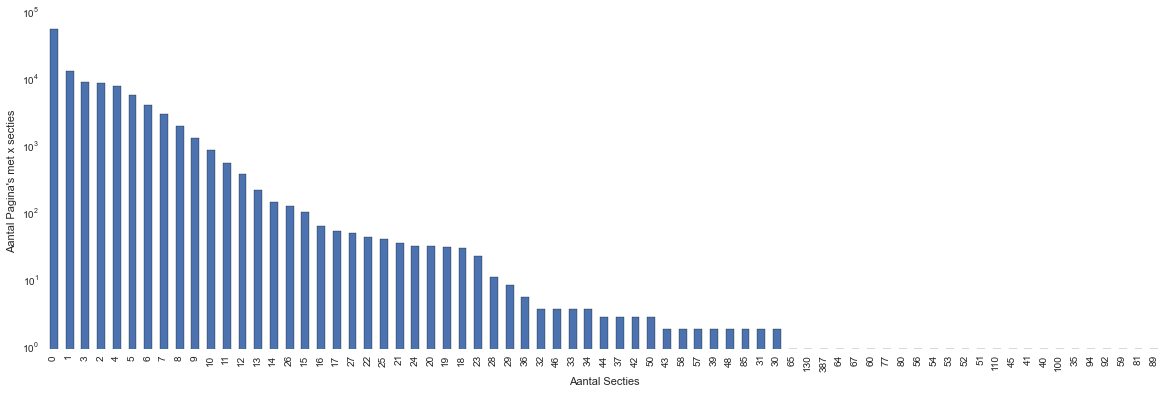

In [88]:
#6

import matplotlib.pyplot as plt
import seaborn as sn

ax = df.Aantal_Secties.value_counts().plot(kind='bar', figsize=(20,6), logy=True)
ax.set_xlabel("Aantal Secties")
ax.set_ylabel("Aantal Pagina's met x secties")

In [89]:
#7

# Average Amount of Sections
average = float(df.Aantal_Secties.sum())/ float(len(df))
print "The average amount of sections is %s." % average

# Median
amount = len(df)
medianindex = int(amount/2)
placeholder = df['Aantal_Secties'].copy()
placeholder.sort(ascending=True)
median = placeholder.iloc[medianindex]
print "The median found using an index is %s." % median

# Standard Deviation
values = [float(i) for i in df.Aantal_Secties] 
mean = sum(values) / len(values)
var  = sum(pow(x-mean,2) for x in values) / amount  
std  = math.sqrt(var)
print "The standard deviation is %s." % std

# Amount of pages without sections; these can not be considered missing values as not every page needs sections to explain what
# a certain topic or thing is about. 0 simply means a lack of sections within a page. 
print "The amount of pages without sections is %s." % len(df[df.Aantal_Secties == 0])

# Title and amount of sections for the page with the most amount of sections (Lijst van baletten, 387)
df[df.Aantal_Secties == df.Aantal_Secties.max()]

The average amount of sections is 2.05946457211.
The median found using an index is 1.
The standard deviation is 3.4889329976.
The amount of pages without sections is 59527.


Titel  Aantal_Secties  \
Page_ID                                        
215903   Lijst van balletten             387   

                                               Sectienamen  Aantal_Woorden  
Page_ID                                                                     
215903   [ A ,  [[Komei Abe]] ,  [[Jean Absil]] ,  [[Ad...            5768

Aantal_Secties  Aantal_Woorden
Aantal_Secties        1.000000        0.530818
Aantal_Woorden        0.530818        1.000000

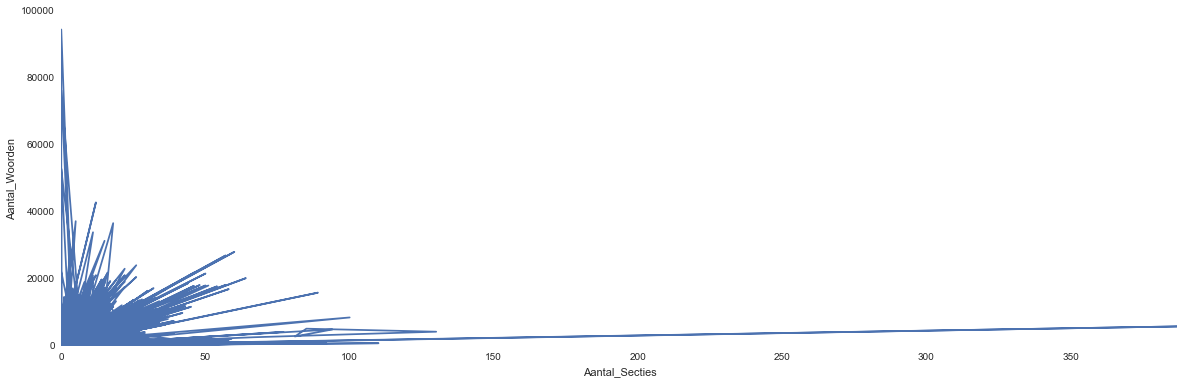

In [90]:
#8

import numpy as np

ax = df.plot(x = "Aantal_Secties", y="Aantal_Woorden", figsize = (20,6), legend=False)
ax.set_xlim(0, df.Aantal_Secties.max())
ax.set_xlabel("Aantal_Secties")
ax.set_ylabel("Aantal_Woorden")

# Correlatie = 0.530818
df.corr()

def SectionText():

    with BZ2File(dumps) as xml_file:    
        context = etree.iterparse(xml_file,  tag= '{http://www.mediawiki.org/xml/export-0.10/}page')
        for _, elem in context:
                # Sections
                text = elem.findtext('{http://www.mediawiki.org/xml/export-0.10/}revision/{http://www.mediawiki.org/xml/export-0.10/}text')
                # Only take Head sections, not subsections!
                sectionpattern = re.compile(r'^==([\w\s].*?)==$', re.MULTILINE)
                sec = [i for i in re.findall(sectionpattern, text) if len(i) > 0]
                # Amount of Words: Only words within sections
                # Remove references
                text = re.sub(r'<ref>(.*?)</ref>', "", text)
                # Only take text up until the Appendix
                appendix = re.compile(r'{{Appendix[\s\S]*')
                text = re.sub(appendix, "", text)
                # Remove Infobox
                infobox = re.compile(r'{{Infobox[\s\S]*?}}[\n][^|]')
                text = re.sub(infobox, "", text)  
                # Remove non-section text
                
                

                L.append((len(sec), sec, len(text)))
                
                # now get rid of the element and also delete all its ancestors   
                # from http://stackoverflow.com/questions/12160418/why-is-lxml-etree-iterparse-eating-up-all-my-memory
                elem.clear()
                # Also eliminate now-empty references from the root node to elem
                for ancestor in elem.xpath('ancestor-or-self::*'):
                    while ancestor.getprevious() is not None:
                        del ancestor.getparent()[0]    
                
        del context
        df = pd.DataFrame(L, columns = ('Aantal_Secties', 'Sectienamen', 'Aantal_Woorden'))
        return df
                                    
df1 = SectionText()

c=0
with BZ2File(dumps) as xml_file: 
    context = etree.iterparse(xml_file,  tag= '{http://www.mediawiki.org/xml/export-0.10/}page')
    for _, elem in context:
            # Sections
            text = elem.findtext('{http://www.mediawiki.org/xml/export-0.10/}revision/{http://www.mediawiki.org/xml/export-0.10/}text')
            sec = [i for i in re.findall(r'==(.*?)==', text) if len(i) > 1]
            # Amount of Words: Only words within sections
            # Remove references
            text = re.sub(r'<ref>(.*?)</ref>', "", text)
            # Remove Infobox
            infobox = re.compile(r'{{Infobox[\s\S]*?}}[\n][^|]')
            text = re.sub(infobox, "", text)
            # Only take text up until the Appendix
            appendix = re.compile(r'{{Appendix[\s\S]*')
            text = re.sub(appendix, "", text)
            print sec
            
            c+=1
            if c==2:
                break

In [91]:
#9

# For the average of words per section you want all the words within sections for pages that actually contain sections 
# and divide these by the amount of sections over all those pages. 

# Create a dataframe that only contains words within sections



# Take all pages with sections
sectiedf = df[df.Aantal_Secties >=1]

# Find the amount of words that serve as section titles
# Take only the section titles
titlelist = sectiedf['Sectienamen']
l = [title.encode('utf-8').strip() for titles in titlelist for title in titles]
# Words in each sectiontitle
sec_title_len = [len(l.split()) for l in l]
# Sum all words in section titles
sec_title_words = sum(sec_title_len)

# Take the sum of all words in sections divided by the sum of all page sections
(sectiedf.Aantal_Woorden.sum() - sec_title_words) / sectiedf.Aantal_Secties.sum()

210

In [92]:
#10

#A

# Take all pages with sections
sectiesonly = df[df.Aantal_Secties >=1]

# Take only the section titles
titlelist = sectiesonly['Sectienamen']

l = [title.encode('utf-8').strip() for titles in titlelist for title in titles]

# Top 10
count = Counter(l)
count.most_common(n=10)

[('Zie ook', 17261),
 ('Externe links', 13898),
 ('Externe link', 10439),
 ('Geschiedenis', 8952),
 ('Geboren', 4488),
 ('Geografie', 3608),
 ('Gebeurtenissen', 3240),
 ('Overleden', 3220),
 ('Literatuur', 3073),
 ('Trivia', 3027)]

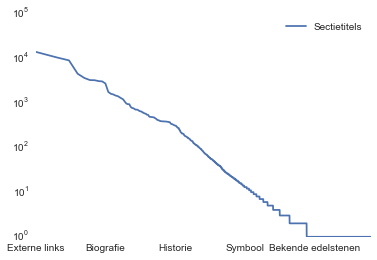

In [98]:
#10

#B

#Convert count to Dictionary
dicty = dict(count)

frame = pd.DataFrame.from_dict(dicty, orient = 'index')
frame.columns = ["Sectietitels"]

frame.sort('Sectietitels', ascending=False).plot(loglog=True)

# The reason why section titles are powerlaw divided, is that few pages share the same kind of section titles, as they
# can range from various kinds of topics. However, certain section titles are commonly used in all pages, such as
# 'Zie ook', 'External Links' or 'Geschiedenis', which means they will occur a lot more often than other section titles. 